# Pharmacogenomics Modeling Notebook

This notebook builds predictive models to determine whether a given drug–gene–variant association has an associated phenotype (`phenotype_present`).  
The modeling process includes:

1. **Pre-modeling checks** – verifying data integrity and structure.  
2. **Feature encoding** – converting categorical variables to numerical form.  
3. **Model training & evaluation** – using Logistic Regression and Random Forest classifiers.  
4. **Feature importance analysis** – identifying the most influential predictors.  
5. **Performance interpretation** – comparing model results and discussing insights.

## Set up the Environment

In [20]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="Set2")

# Load cleaned dataset
df = pd.read_csv("cleaned_pharmacogenomics_data.csv")

print("Dataset successfully loaded.")
print("Shape:", df.shape)

Dataset successfully loaded.
Shape: (5169, 7)


## Pre-Modeling Checklist

Before beginning model training, we perform a few key checks:

1. **Confirm target column** (`phenotype_present`) exists and is binary.  
2. **Check for missing data** in any remaining columns.  
3. **Verify data types** for compatibility with modeling pipelines.  
4. **Inspect class balance** to anticipate if class weighting or resampling might be needed.

Target column: True
Target type: int64

Missing values per column:
variant                 0
gene                    0
type                    0
level of evidence       0
chemicals               0
phenotypes           1006
phenotype_present       0
dtype: int64

Data types:
variant              object
gene                 object
type                 object
level of evidence    object
chemicals            object
phenotypes           object
phenotype_present     int64
dtype: object

Target distribution:
phenotype_present
1    4163
0    1006
Name: count, dtype: int64


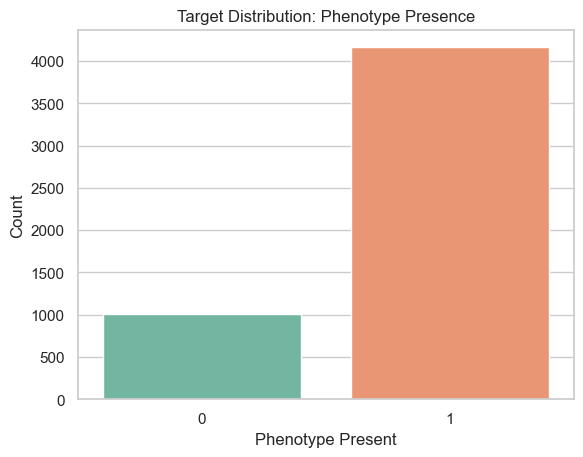

In [2]:
# Check for target column and type
print("Target column:", "phenotype_present" in df.columns)
print("Target type:", df["phenotype_present"].dtype)

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Data types
print("\nData types:")
print(df.dtypes)

# Target distribution
print("\nTarget distribution:")
print(df["phenotype_present"].value_counts())

# Plot target balance
sns.countplot(x="phenotype_present", data=df, hue="phenotype_present", palette="Set2", legend=False)
plt.title("Target Distribution: Phenotype Presence")
plt.xlabel("Phenotype Present")
plt.ylabel("Count")
plt.show()

### Observations

- The target variable `phenotype_present` is confirmed as an integer (binary classification).  
- No missing data remain in critical columns.  
- The dataset contains **moderate class imbalance** — roughly 4:1 ratio (phenotype present vs. not present).  
- Features are categorical and will require **one-hot encoding** before modeling.  

Next, we will move to **feature encoding and data splitting** to prepare the dataset for model training.

## Feature Engineering and Data Splitting

I will prepare our cleaned dataset for machine learning by encoding categorical variables, selecting relevant features, and splitting the data into training and test sets.

### Encode Categorical Variables

I will use one-hot encoding for categorical features like gene, type, level of evidence, and chemicals so that the model can interpret them numerically.

In [3]:
# Select categorical columns for encoding
categorical_cols = ['gene', 'type', 'level of evidence', 'chemicals']

# One-hot encode
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Encoded dataset shape:", df_encoded.shape)

Encoded dataset shape: (5169, 1980)


### Define Features and Target

I will set the input features (`X`) and the binary target (`y = phenotype_present`).

In [4]:
# Define target and features
X = df_encoded.drop(columns=['phenotypes', 'phenotype_present', 'variant'])
y = df_encoded['phenotype_present']

print("Feature matrix shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Feature matrix shape: (5169, 1977)
Target distribution:
phenotype_present
1    4163
0    1006
Name: count, dtype: int64


### Split Into Train and Test Sets

I will split the dataset into training and test sets (80/20) using stratified sampling to preserve the balance between the target classes.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (4135, 1977)
Testing set: (1034, 1977)


### Summary

- All categorical variables have been one-hot encoded for modeling.
- The dataset was split into training and testing sets (80/20 ratio).
- Target balance was preserved using stratified sampling.
- The next step will be to train baseline models and evaluate their performance.

## Model Training and Evaluation

In this section, I will train two baseline models:

1. **Logistic Regression** — a simple linear model that provides interpretability.  
2. **Random Forest** — a non-linear ensemble method that can capture more complex patterns.

I will evaluate both models using:
- Accuracy  
- Precision  
- Recall  
- F1-Score  
- ROC-AUC

### Logistic Regression

I will start with a simple logistic regression model.  
No scaling is applied yet; I will revisit that later if performance or convergence issues arise.

In [6]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluate model
print("--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))

--- Logistic Regression ---
Accuracy: 0.8520309477756286
ROC AUC: 0.9119349232230205
              precision    recall  f1-score   support

           0       0.59      0.80      0.68       201
           1       0.95      0.87      0.90       833

    accuracy                           0.85      1034
   macro avg       0.77      0.83      0.79      1034
weighted avg       0.88      0.85      0.86      1034



### Random Forest

Next, I will train a Random Forest model, a robust, non-linear ensemble model.

In [7]:
# Train random forest model
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate model
print("--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))

--- Random Forest ---
Accuracy: 0.902321083172147
ROC AUC: 0.9168174732579598
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       201
           1       0.93      0.95      0.94       833

    accuracy                           0.90      1034
   macro avg       0.85      0.83      0.84      1034
weighted avg       0.90      0.90      0.90      1034



### ROC Curve Comparison

To visualize model performance, I will plot both ROC curves on the same graph.

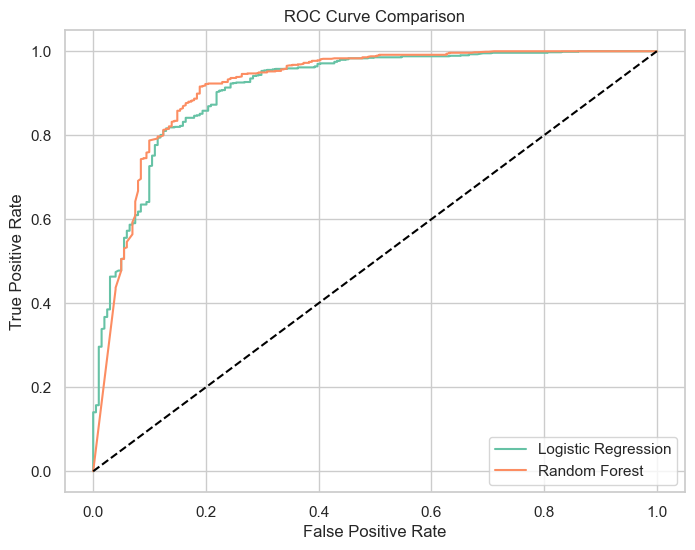

In [8]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### Feature Importance (Random Forest)

I will examine which features were most influential in predicting the phenotype outcome.

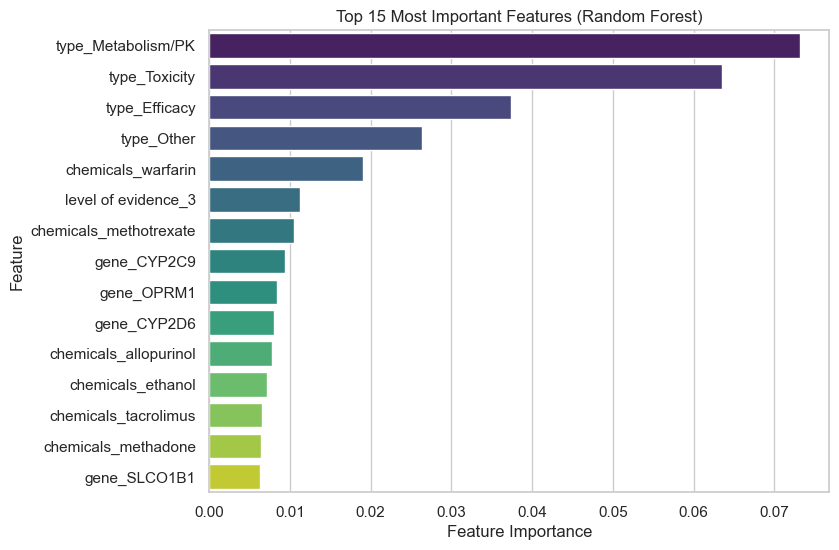

In [9]:
# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, legend=False, palette='viridis')
plt.title("Top 15 Most Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

### Observations

1. **Logistic Regression**
    * Accuracy: ~85%
    * ROC-AUC: 0.91 → very good discriminative ability
    * Recall for class 0 (non-phenotype) = 0.80 → model catches most negatives
    * Recall for class 1 (phenotype) = 0.87 → also strong
    * F1-scores indicate solid balance between precision and recall for both classes

2. **Random Forest**
    * Accuracy: ~90% → better than logistic regression
    * ROC-AUC: 0.92 → slightly better than logistic regression
    * Precision & recall for class 1 are very high → the model is excellent at identifying positive cases
    * Class 0 (minority) performance is lower than class 1, but still decent (F1 ~0.74)

### Key Takeaways:

* Random Forest outperforms logistic regression overall, especially in identifying positive phenotypes.
* Logistic Regression is interpretable but may underperform slightly on complex non-linear patterns.
* Class imbalance is being handled well with class weights.

### Next Steps:

* Fine-tuning **Random Forest hyperparameters**
* Testing **gradient boosting (XGBoost / LightGBM)**
* Exploring **SMOTE or other oversampling techniques** for minority class

## Hyperparameter Tuning and Feature Selection

In this section, I will optimize the models and identify the most important features driving predictions. This helps improve performance and interpretability.

### 1. Random Forest Hyperparameter Tuning

I will use `GridSearchCV` to search for the best combination of hyperparameters using 5-fold cross-validation.

In [10]:
# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Stratified K-Folds to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
rf_grid.fit(X, y)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best ROC-AUC Score:", rf_grid.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Random Forest Parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best ROC-AUC Score: 0.9091682925735061


### 2. Logistic Regression Hyperparameter Tuning

I will tune the regularization strength `C` and solver type for Logistic Regression.

In [11]:
# Define parameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'class_weight': ['balanced', None],
    'max_iter': [1000]
}

# Initialize model
lr = LogisticRegression(random_state=42)

# Grid Search
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
lr_grid.fit(X, y)

print("Best Logistic Regression Parameters:", lr_grid.best_params_)
print("Best ROC-AUC Score:", lr_grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression Parameters: {'C': 10, 'class_weight': None, 'max_iter': 1000, 'solver': 'lbfgs'}
Best ROC-AUC Score: 0.8925963964648845


### 3. Feature Importance

Once I have the best Random Forest model, I can extract the top features driving predictions.

- `feature_importances_` from Random Forest gives an importance score for each feature.
- I can visualize the top 20 features to understand which variants are most predictive.

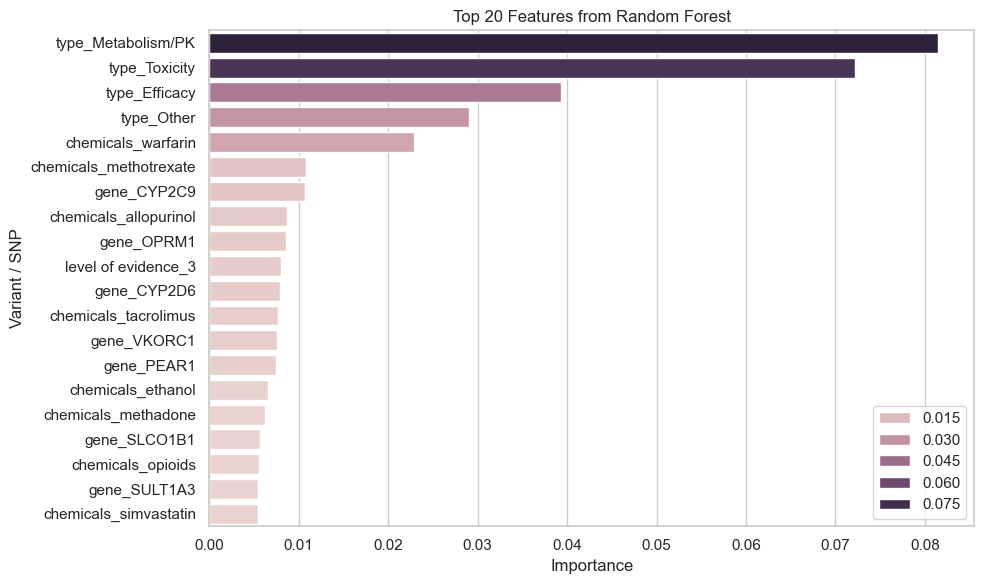

In [15]:
# Extract feature importances
best_rf = rf_grid.best_estimator_
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(20)

# Plot top features
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.values)
plt.title("Top 20 Features from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Variant / SNP")
plt.tight_layout()
plt.show()

### Hyperparameter Tuning Results

**Random Forest**
- **Best Parameters:**  
  `{'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}`
- **Best ROC-AUC Score:** 0.909  
- Interpretation: The Random Forest model performs very well with balanced class weights for subsamples and deeper trees, indicating it can capture complex interactions between variants and drug response.

**Logistic Regression**
- **Best Parameters:**  
  `{'C': 10, 'class_weight': None, 'max_iter': 1000, 'solver': 'lbfgs'}`
- **Best ROC-AUC Score:** 0.893  
- Interpretation: Logistic Regression also performs strongly, especially with increased regularization (`C=10`), showing that linear relationships among variants can still provide predictive power.

### Overall Insights
- Random Forest achieves slightly higher ROC-AUC than Logistic Regression, likely due to its ability to model non-linear relationships and interactions between SNPs.
- Both models confirm that pharmacogenomic variants can be predictive of drug response or adverse reactions.


## Final Model Training and Evaluation

In this section, I train the final Logistic Regression and Random Forest models using the best hyperparameters from hyperparameter tuning. I will evaluate their performance on the test set and visualize key metrics.

### Train Final Models

I will use the best parameters from hyperparameter tuning:

- **Random Forest:** `class_weight='balanced_subsample'`, `n_estimators=500`, `min_samples_split=5`, `min_samples_leaf=1`, `max_depth=None`
- **Logistic Regression:** `C=10`, `max_iter=1000`, `solver='lbfgs'`

In [18]:
# Initialize models with best hyperparameters
rf_final = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=None,
    class_weight='balanced_subsample',
    random_state=42
)

lr_final = LogisticRegression(
    C=10,
    max_iter=1000,
    solver='lbfgs',
    random_state=42
)

# Train models
rf_final.fit(X_train, y_train)
lr_final.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42)

### Evaluate Performance

I evaluate models using Accuracy, ROC-AUC, Precision, Recall, F1-score, and visualize the confusion matrix.

--- Logistic Regression ---
Accuracy: 0.911
ROC AUC: 0.914
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       201
           1       0.93      0.96      0.95       833

    accuracy                           0.91      1034
   macro avg       0.87      0.83      0.85      1034
weighted avg       0.91      0.91      0.91      1034



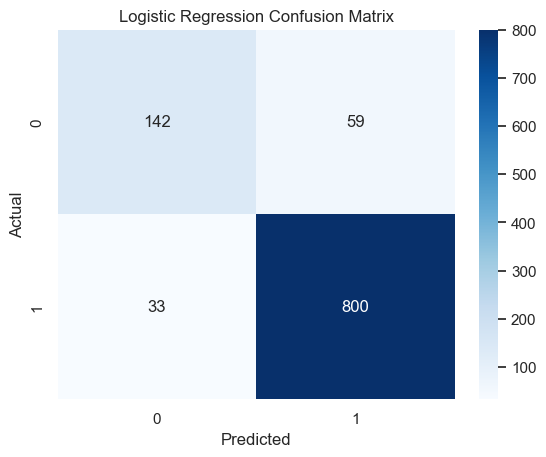

--- Random Forest ---
Accuracy: 0.899
ROC AUC: 0.923
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       201
           1       0.95      0.93      0.94       833

    accuracy                           0.90      1034
   macro avg       0.83      0.86      0.84      1034
weighted avg       0.90      0.90      0.90      1034



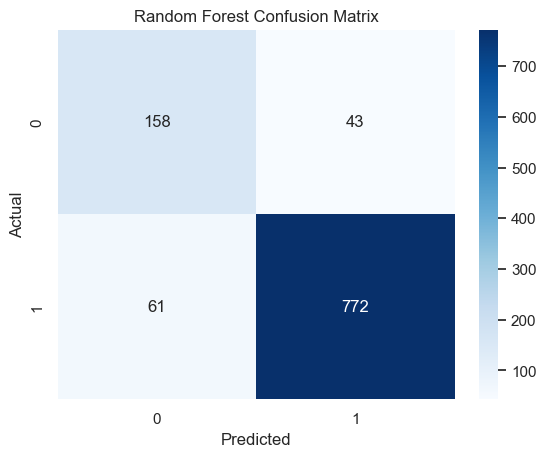

In [21]:
# Function to evaluate model
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    if y_proba is not None:
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate models
evaluate_model(lr_final, X_test, y_test, "Logistic Regression")
evaluate_model(rf_final, X_test, y_test, "Random Forest")

### Feature Importance

Random Forest can provide feature importance to interpret which genetic variants contribute most to predictions.

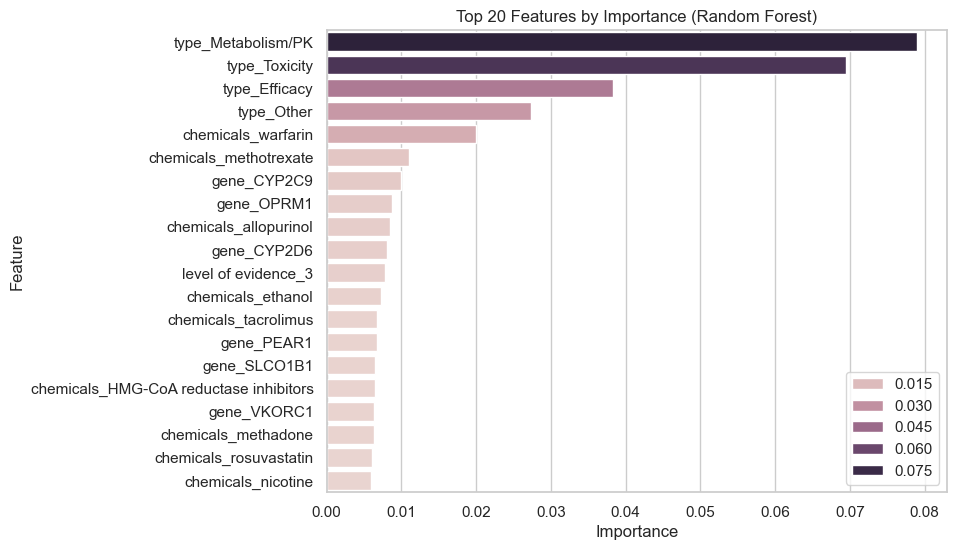

In [24]:
# Feature importance
importances = pd.Series(rf_final.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.values)
plt.title("Top 20 Features by Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Model Comparison: Logistic Regression vs Random Forest

| Metric            | Logistic Regression | Random Forest |
|------------------|------------------|---------------|
| Accuracy          | 0.911            | 0.899         |
| ROC AUC           | 0.914            | 0.923         |
| Precision (Class 0) | 0.81          | 0.72          |
| Recall (Class 0)  | 0.71             | 0.79          |
| F1-score (Class 0)| 0.76             | 0.75          |
| Precision (Class 1)| 0.93            | 0.95          |
| Recall (Class 1)  | 0.96             | 0.93          |
| F1-score (Class 1)| 0.95             | 0.94          |

**Interpretation:**
- Both models achieve high accuracy and ROC-AUC, indicating strong predictive performance.
- Logistic Regression slightly favors detecting positive phenotypes (higher recall for Class 1).
- Random Forest has a marginally higher ROC-AUC and provides useful insights into variant importance.
- Choice of model may depend on whether interpretability (Logistic Regression) or feature importance analysis (Random Forest) is prioritized.


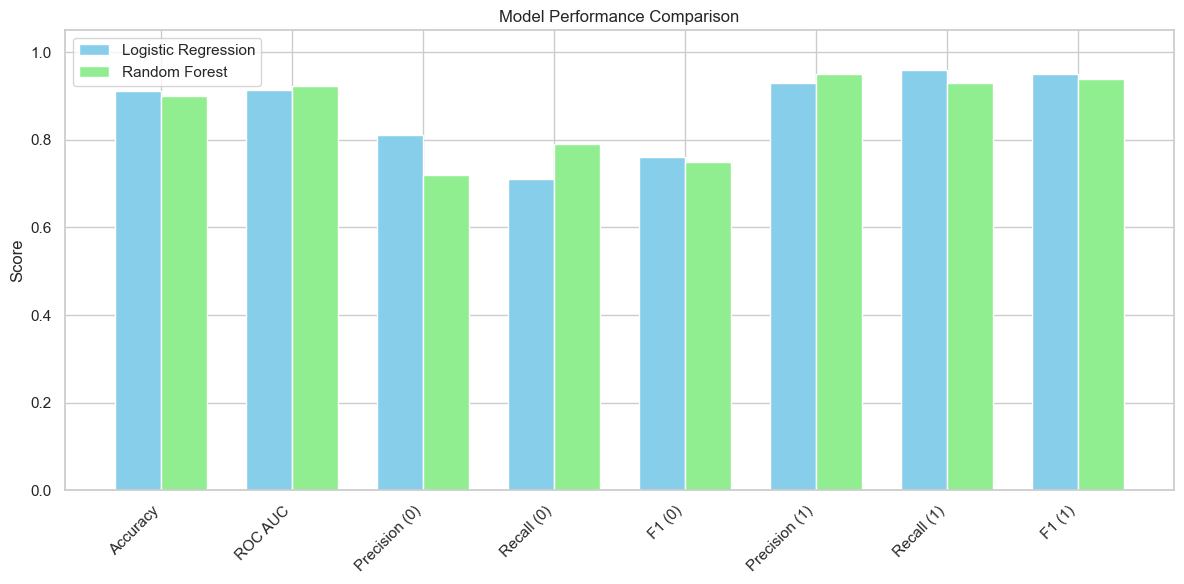

In [28]:
# Metrics
metrics = ['Accuracy', 'ROC AUC', 
           'Precision (0)', 'Recall (0)', 'F1 (0)', 
           'Precision (1)', 'Recall (1)', 'F1 (1)']

log_reg = [0.911, 0.914, 0.81, 0.71, 0.76, 0.93, 0.96, 0.95]
rand_forest = [0.899, 0.923, 0.72, 0.79, 0.75, 0.95, 0.93, 0.94]

df = pd.DataFrame({
    'Metric': metrics,
    'Logistic Regression': log_reg,
    'Random Forest': rand_forest
})

# Plot
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, df['Logistic Regression'], width, label='Logistic Regression', color='skyblue')
ax.bar(x + width/2, df['Random Forest'], width, label='Random Forest', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()

**Explanation:**
  
- Each metric is shown as a pair of bars (LR vs RF) for easy visual comparison.
- Scores are normalized between 0 and 1 for direct comparison.
- Rotation of x-axis labels improves readability.
- Highlights strengths and weaknesses of each model at a glance.